# Step 1: Implement the vector median filter for colour images.

Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation hints are available in the assignment description PDF.   

The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.

Your function should accept images of dtype `uint8` or `float`.    It is easiest if you work with the image as data type `float`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float`, construct the output image also as type `float` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [2]:
def vector_median(I, radius):
    
    # Fill in the function here.
    img_is_flt = False
    
    if I.dtype == np.uint8:
        I = util.img_as_float(I)
        img_is_flt = True
        
    vmf = np.zeros((I.shape[0], I.shape[1], I.shape[2]))
    npad = ((radius, radius), (radius, radius), (0, 0))
    I = np.pad(I, pad_width=npad, mode='edge')
    
    for row in range(vmf.shape[0]):
        for col in range(vmf.shape[1]):
            nghbr = I[row : row+2*radius+1, col:col+2*radius+1, :]
            clrs = np.reshape(nghbr, [nghbr.shape[0] * nghbr.shape[1], 3])
            Y = np.tile(np.expand_dims(clrs, axis=2), (1, 1, clrs.shape[0]))
            X = np.transpose(Y, (2, 1, 0))
            vmf[row, col, :] = Y[np.argmin(np.sum(np.abs(X-Y), axis=(0, 1))), :, 0]

    if img_is_flt:
        vmf = util.img_as_ubyte(vmf)
    
    return vmf

# Step 2: Establish a Baseline

Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list. 

Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.  

The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skimage.measure.compare_psnr()` and `skimage.measure.compare_ssim()`.  You'll need the `multichannel=true` argument for `compare_ssim()`.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._


In [1]:
# Some modules you might need.

import skimage.io as io
import os as os
import skimage.filters as filt
import skimage.measure as meas
import skimage.util as util
import numpy as np

%matplotlib inline

I_noisy_PSNR = []
I_noisy_SSIM = []
I_denoised_PSNR = []
I_denoised_SSIM = []
# For every file in the noisy images folder...
for root, dirs, files in os.walk('images/noisy-test'):
    for filename in files:
        
        # construct the full filename
        fname = os.path.join(root, filename)
        
        # In case these metadata files show up in the folders, ignore them.
        if filename == '.DS_Store':   
            continue
        
        I_noisy = io.imread(fname)
        I_noiseless = io.imread(os.path.join('images/noiseless', filename))
        I_denoised = vector_median(I_noisy, 1)
        io.imsave(os.path.join('images/denoised', filename), I_denoised)
        
        if I_noisy.dtype != I_noiseless.dtype:
            I_noisy = util.dtype.convert(I_noisy, I_noiseless.dtype)
            
        if I_denoised.dtype != I_noiseless.dtype:
            I_denoised = util.dtype.convert(I_denoised, I_noiseless.dtype)
        
        # Process image noisy file 'fname' here.  The images have the same filenames name in the 
        # noisy, noisy-test, and noiseless folders.  You'll have to construct the path to the
        # noiseless images yourself.  It's easy using os.path.join(), as above.
        I_noisy_PSNR.append(meas.compare_psnr(I_noiseless, I_noisy))
        I_noisy_SSIM.append(meas.compare_ssim(I_noiseless, I_noisy, multichannel=True))
        I_denoised_PSNR.append(meas.compare_psnr(I_noiseless, I_denoised))
        I_denoised_SSIM.append(meas.compare_ssim(I_noiseless, I_denoised, multichannel=True))

NameError: name 'vector_median' is not defined

# Step 2: Compute average baseline metrics.

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

(0, 1)

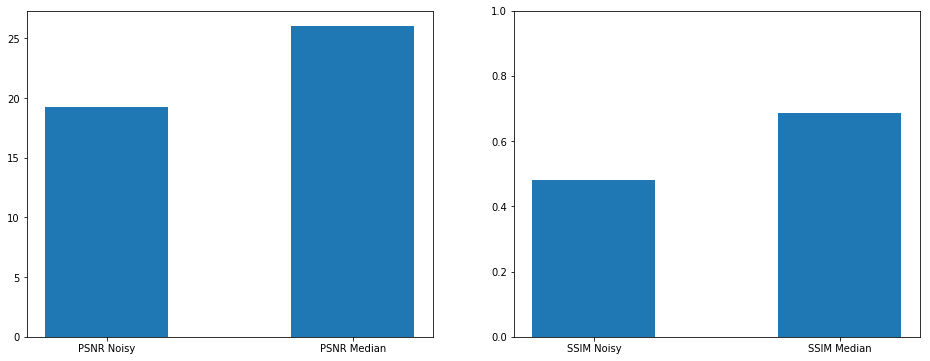

In [3]:
# some modules you might need.

import matplotlib.pyplot as plt
import numpy as np

plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1) 
plt.bar([0.5,1.5],[np.mean(I_noisy_PSNR),np.mean(I_denoised_PSNR)],width=0.5)
plt.xticks([0.5,1.5], ('PSNR Noisy', 'PSNR Median'))

plt.subplot(1,2,2) 
plt.bar([0.5,1.5],[np.mean(I_noisy_SSIM),np.mean(I_denoised_SSIM)],width=0.5)
plt.xticks([0.5,1.5], ('SSIM Noisy', 'SSIM Median'))
plt.ylim((0, 1)) 

# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


In [4]:
# Write your de-noising method here.
from skimage.restoration import denoise_wavelet
import skimage.util as util

I_mine_PSNR = []
I_mine_SSIM = []
# For every file in the noisy images folder...
for root, dirs, files in os.walk('images/noisy-test'):
    for filename in files:
        
        # construct the full filename
        fname = os.path.join(root, filename)
        
        # In case these metadata files show up in the folders, ignore them.
        if filename == '.DS_Store':   
            continue
        
        I_noiseless = io.imread(os.path.join('images/noiseless', filename))
        I_vmf = io.imread(os.path.join('images/denoised', filename))
        I_mine = denoise_wavelet(I_vmf, multichannel=True)
        
        if I_mine.dtype != I_noiseless.dtype:
            I_mine = util.dtype.convert(I_mine, I_noiseless.dtype)
        
        I_mine_PSNR.append(meas.compare_psnr(I_noiseless, I_mine))
        I_mine_SSIM.append(meas.compare_ssim(I_noiseless, I_mine, multichannel=True))

/Users/wbb/anaconda3/envs/cmpt819/lib/python3.7/site-packages/skimage/restoration/_denoise.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return pywt.waverecn(denoised_coeffs, wavelet)[original_extent]
/Users/wbb/anaconda3/envs/cmpt819/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/wbb/anaconda3/envs/cmpt819/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different resu

(0, 1)

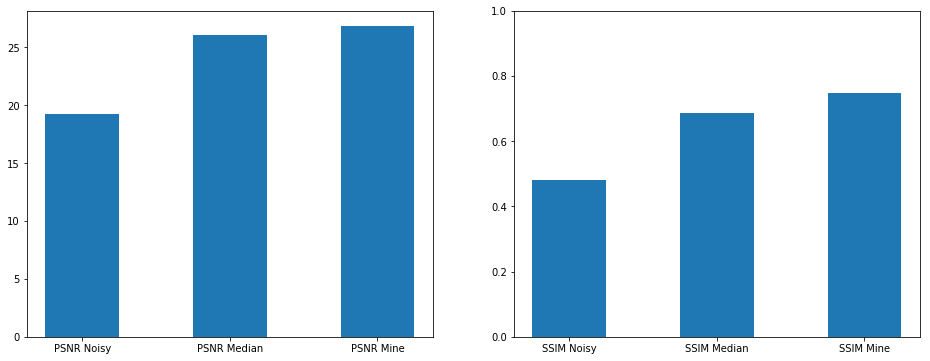

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplots(1,2,figsize=(16, 6))
plt.subplot(1,2,1) 
plt.bar([0.5,1.5,2.5],[np.mean(I_noisy_PSNR),np.mean(I_denoised_PSNR),np.mean(I_mine_PSNR)],width=0.5)
plt.xticks([0.5,1.5,2.5], ('PSNR Noisy', 'PSNR Median', 'PSNR Mine'))

plt.subplot(1,2,2) 
plt.bar([0.5,1.5,2.5],[np.mean(I_noisy_SSIM),np.mean(I_denoised_SSIM), np.mean(I_mine_SSIM)],width=0.5)
plt.xticks([0.5,1.5,2.5], ('SSIM Noisy', 'SSIM Median', 'SSIM Mine'))
plt.ylim((0, 1)) 